## Goals
- Handle the missing values
- Handle the categorical variables
- Handle the Outliers
- Implement pipelines
- Visualize the data
- Check the distributions of the data
- Check the correlations among the features
- Find insights from the data
- Save the pipelines for model

## Imports

In [1]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import pickle
import os

# Notebook Utilities
%matplotlib inline

In [2]:
# Pipelines
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Transformers
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

# Scalers
from sklearn.preprocessing import MinMaxScaler

# Parameter Tuning
from sklearn.model_selection import GridSearchCV

## Functions

In [3]:
# Function which seperates feature types
def data_seperator(data, depend=None):
    # Stores dependant variable
    if depend != None:
        data_depend = data[depend]
        data = data.drop(depend, axis=1)
    else:
        data_depend = []
    
    # Stores categorical features
    select = [data.columns[i] for i in np.where(data.dtypes == 'O')[0]]
    data_categ = pd.DataFrame(data[select])
    
    # Stores all numerical features
    data_num = data.drop(select, axis=1)
    
    # Seperating time features from numerical features
    select = [i for i in data_num.columns if 'year' in i.lower() or 'yr' in i.lower() or 'day' in i or 'week' in i.lower()]
    data_time = pd.DataFrame(data_num[select])
    data_num = data_num.drop(select, axis=1)
    
    # Seperating discrete and continuous features
    select = [feature for feature in data_num if len(data_num[feature].unique()) < 10]
    data_discrete = pd.DataFrame(data_num[select])
    data_continuous = data_num.drop(select, axis=1)
    
    # Returning the features
    return data_num, data_discrete, data_continuous, data_categ, data_time, data_depend

In [4]:
def impute_cabin(data):
    data['Cabin'] = data['Cabin'].fillna('N')
    for i in data['Cabin'].unique():
        data['Cabin'].replace(i, i[0], inplace=True)

In [5]:
def impute_first_letter(df):
    for i in range(len(df)):
        for x in range(len(df[i])):
            df[i][x] = df[i][x][0]
    return df

## Dataset Information
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

- Source: https://www.kaggle.com/competitions/titanic/data
- Use Machine Learning to create a model that predicts which passengers survived the Titanic shipwreck.
- I chose this dataset because it has many types of features. 
- It has features with missing values and outliers
- Overall, I think this is a good dataset for practicing the basics.

## Working Directory

In [6]:
old_path = os.getcwd()
os.chdir('..')
path = os.getcwd()

## Reading Data

In [7]:
data = pd.read_csv('data/raw/train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Dropping the Unnecessary Features

In [8]:
data = data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

## Separating the data
Seperated the data into different variables for ease of access and keeping the original data as backup

In [9]:
data_num, data_discrete, data_continuous, data_categ, data_time, data_depend = data_seperator(data, 'Survived')

In [10]:
data_continuous.head()

,Age,Fare
0,22.0,7.2500
1,38.0,71.2833
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500


## Organizing the Data

In [11]:
data = pd.concat([data_continuous, data_discrete, data_categ, data_time, data_depend], axis=1)

## Piplelines

In [12]:
steps = [
    ("Imputer", KNNImputer(missing_values=np.nan)),
    ("Scaler", MinMaxScaler())
    
]

impute_continuous = Pipeline(steps)

In [13]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ("Encoder", OneHotEncoder(drop='first', handle_unknown = 'ignore'))
]

impute_categ = Pipeline(steps)

In [14]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
]

impute_discrete = Pipeline(steps)

In [15]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='N')),
    ("Scaler", FunctionTransformer(impute_first_letter, feature_names_out='one-to-one')),
    ("Encoder", OneHotEncoder(drop='first', handle_unknown='ignore'))
]

impute_cabin = Pipeline(steps)

## Column Transformer

In [16]:
continuous = data_continuous.columns
discrete = data_discrete.columns
categorical = data_categ.drop('Cabin', axis=1).columns
cabin = np.array(['Cabin'])

In [17]:
transformers = [
    ("Continuous", impute_continuous, continuous), 
    ("Discrete", impute_discrete, discrete),
    ("Categorical", impute_categ, categorical),
    ("Cabin", impute_cabin, cabin)
]

preprocessor = ColumnTransformer(transformers, remainder='drop')

## Train-Test Split

In [18]:
x = data.drop('Survived', axis=1)
y = data.Survived

# Splitting the data into test and train sets
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=0)

In [19]:
x_train = x
y_train = y
x_test = pd.read_csv('data/external/new_x_test.csv')
y_test = pd.read_csv('data/external/new_y_test.csv').drop('PassengerId', axis=1)

## Fitting the training values

In [20]:
preprocessor.fit(x_train, y_train)

ColumnTransformer(transformers=[('Continuous',
                                 Pipeline(steps=[('Imputer', KNNImputer()),
                                                 ('Scaler', MinMaxScaler())]),
                                 Index(['Age', 'Fare'], dtype='object')),
                                ('Discrete',
                                 Pipeline(steps=[('Imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 Index(['Pclass', 'SibSp', 'Parch'], dtype='object')),
                                ('Categorical',
                                 Pipeline(steps=[('Imputer',
                                                  SimpleImputer(strategy=...
                                                                handle_unknown='ignore'))]),
                                 Index(['Sex', 'Embarked'], dtype='object')),
                                ('Cabin',
                                 Pipeline(steps=[('Imputer',
                                                  SimpleImputer(fill_value='N',
                                                                strategy='constant')),
                                                 ('Scaler',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function impute_first_letter at 0x000001680088EB90>)),
                                                 ('Encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 array(['Cabin'], dtype='<U5'))])

## Extracting the feature names

In [21]:
feature_names = []
for i in preprocessor.named_transformers_:
    features = preprocessor.named_transformers_[i].get_feature_names_out().tolist()
    for feature in features:
        feature_names.append(feature)

## Transformed Data

In [22]:
x_train = pd.DataFrame(preprocessor.fit_transform(x_train, y_train), columns=feature_names)
x_train.head()

,Age,Fare,Pclass,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T
0,0.271174,0.014151,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.472229,0.139136,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.321438,0.015469,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.434531,0.103644,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.434531,0.015713,3.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [23]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         891 non-null    float64
 1   Fare        891 non-null    float64
 2   Pclass      891 non-null    float64
 3   SibSp       891 non-null    float64
 4   Parch       891 non-null    float64
 5   Sex_male    891 non-null    float64
 6   Embarked_Q  891 non-null    float64
 7   Embarked_S  891 non-null    float64
 8   Cabin_B     891 non-null    float64
 9   Cabin_C     891 non-null    float64
 10  Cabin_D     891 non-null    float64
 11  Cabin_E     891 non-null    float64
 12  Cabin_F     891 non-null    float64
 13  Cabin_G     891 non-null    float64
 14  Cabin_N     891 non-null    float64
 15  Cabin_T     891 non-null    float64
dtypes: float64(16)
memory usage: 111.5 KB


## Separating the Data

In [24]:
data_num, data_discrete, data_continuous, data_categ, data_time, data_depend = data_seperator(x_train)

## Data Description

In [25]:
data.describe()

,Age,Fare,Pclass,SibSp,Parch,Survived
count,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,29.699118,32.204208,2.308642,0.523008,0.381594,0.383838
std,14.526497,49.693429,0.836071,1.102743,0.806057,0.486592
min,0.420000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,20.125000,7.910400,2.000000,0.000000,0.000000,0.000000
50%,28.000000,14.454200,3.000000,0.000000,0.000000,0.000000
75%,38.000000,31.000000,3.000000,1.000000,0.000000,1.000000
max,80.000000,512.329200,3.000000,8.000000,6.000000,1.000000


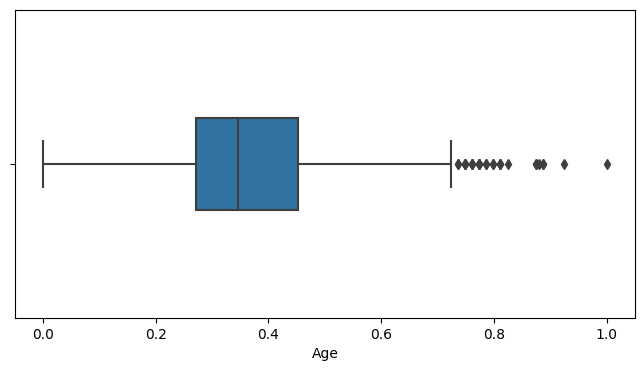

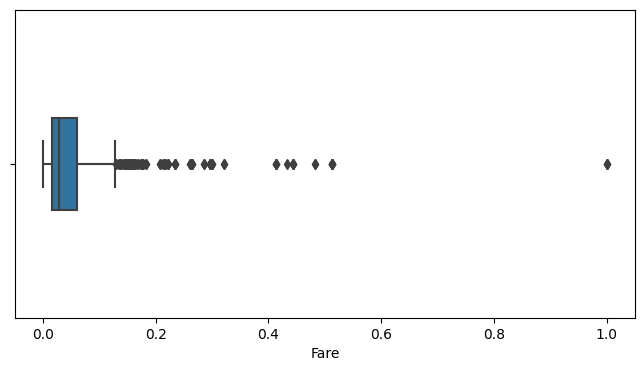

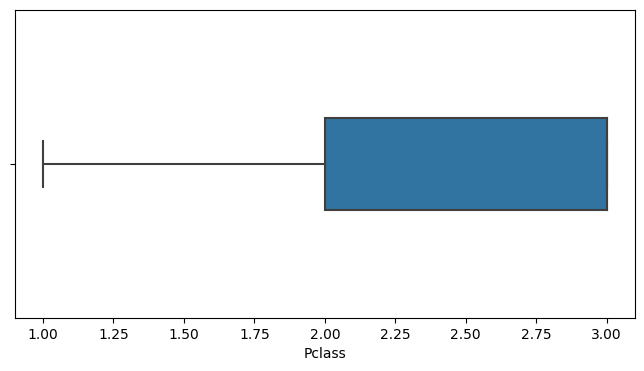

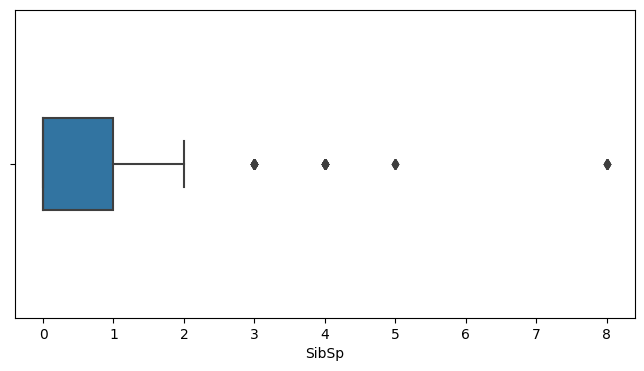

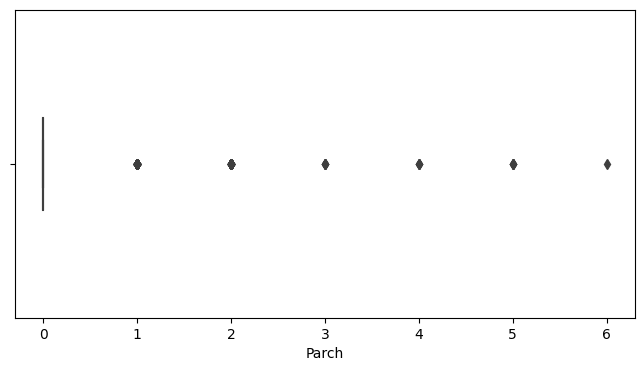

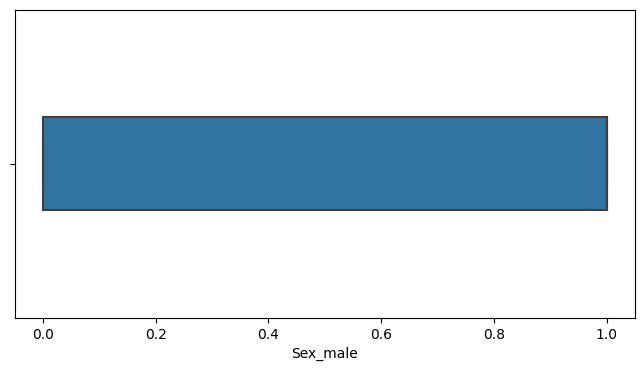

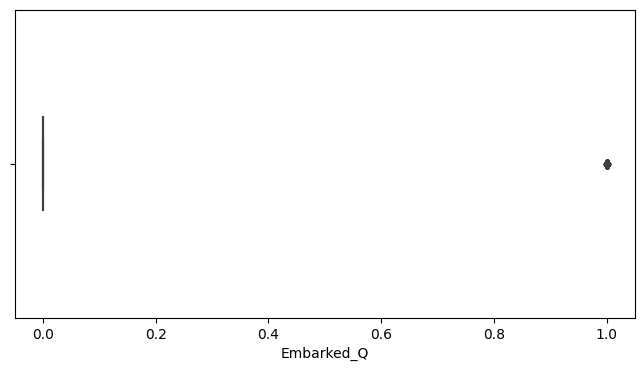

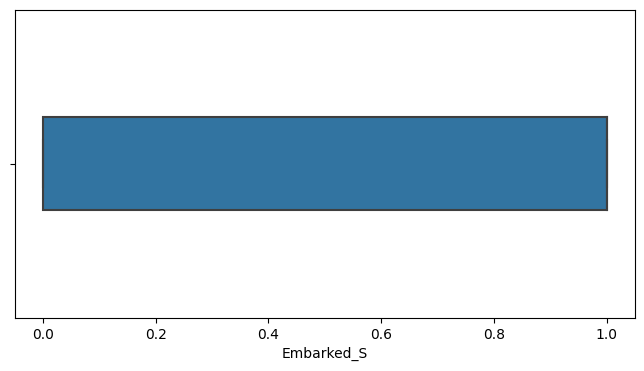

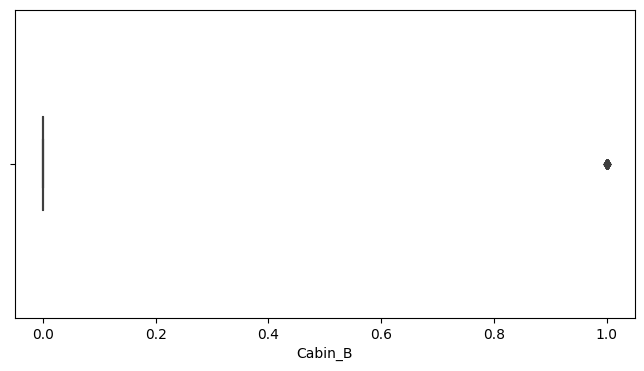

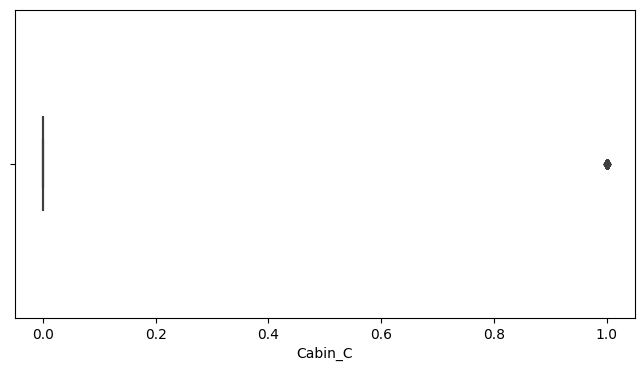

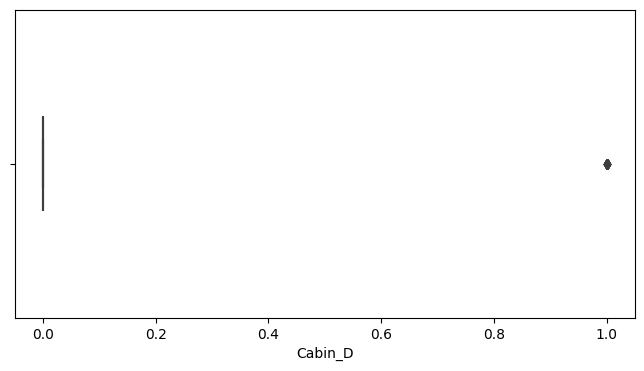

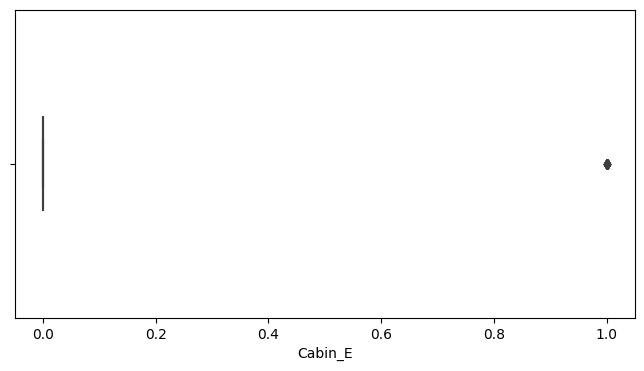

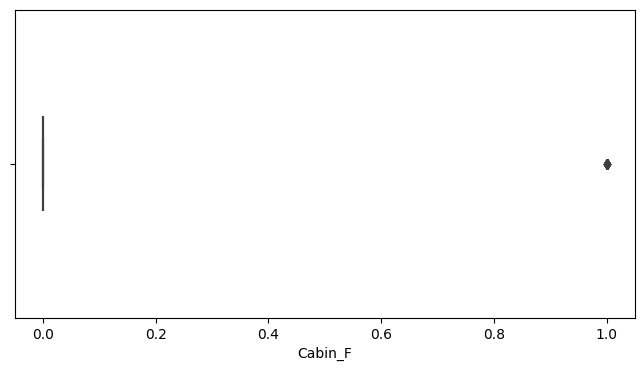

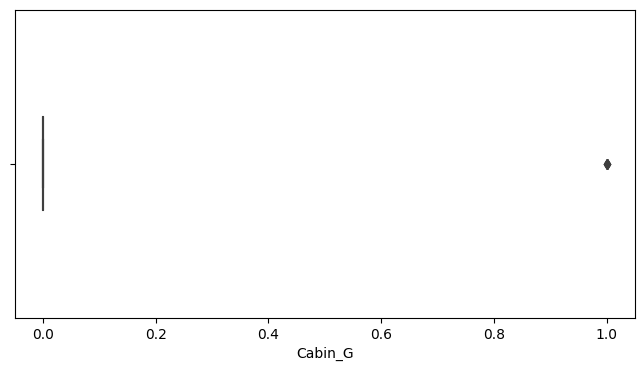

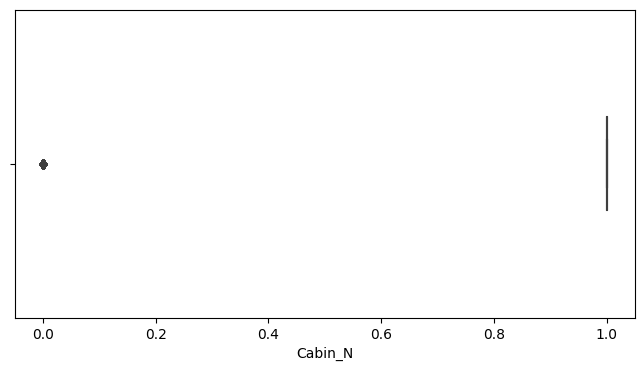

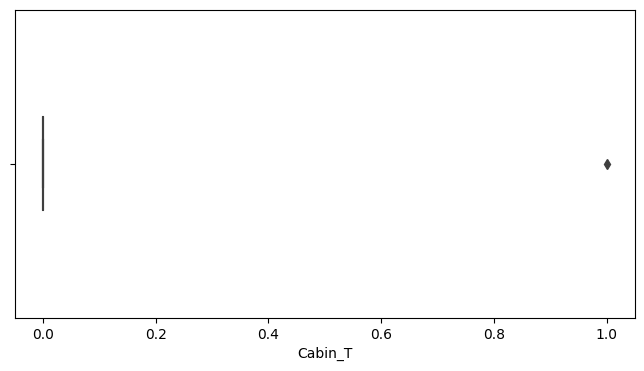

In [26]:
for feature in data_num.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(width=0.3, x=x_train[feature])

## Continuous Data

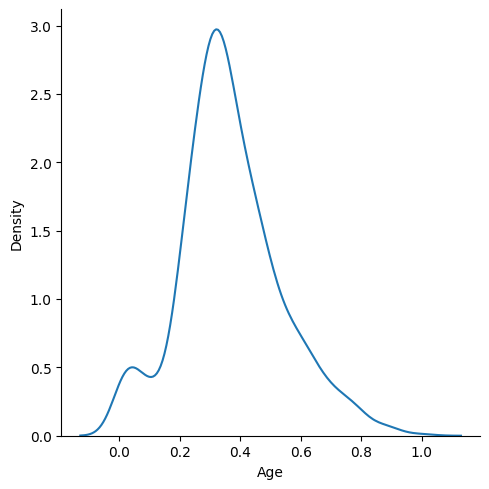

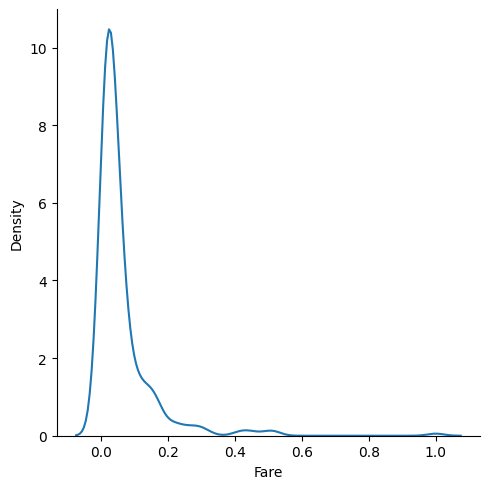

In [27]:
for feature in data_continuous.columns:
    sns.displot(data=x_train[feature], kind='kde')

## Discrete Data

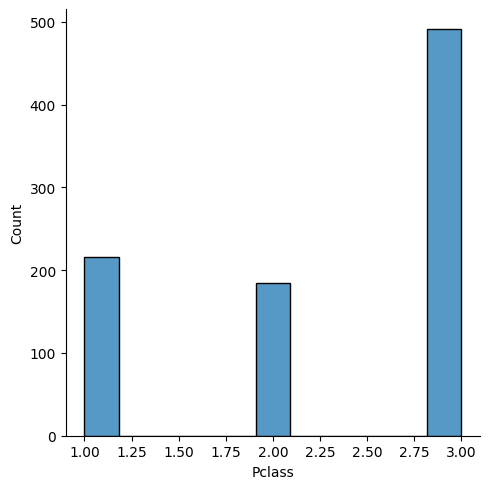

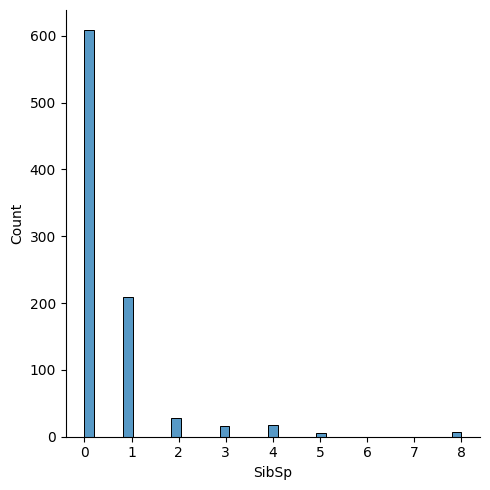

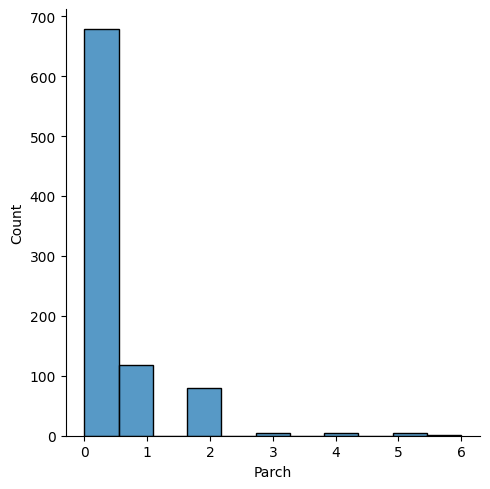

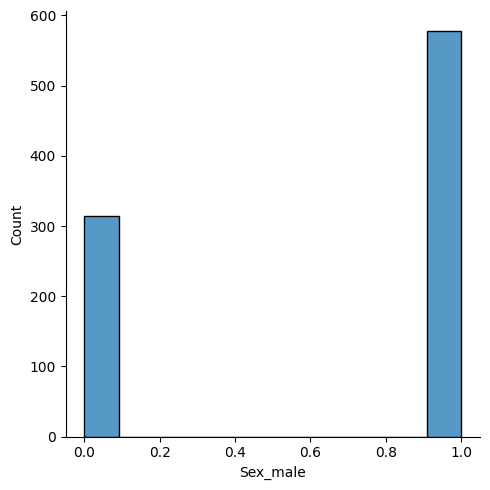

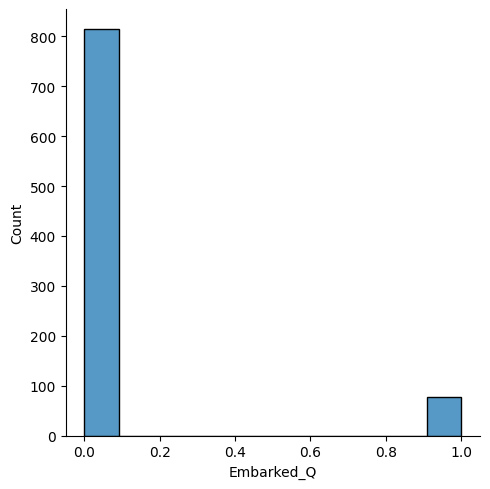

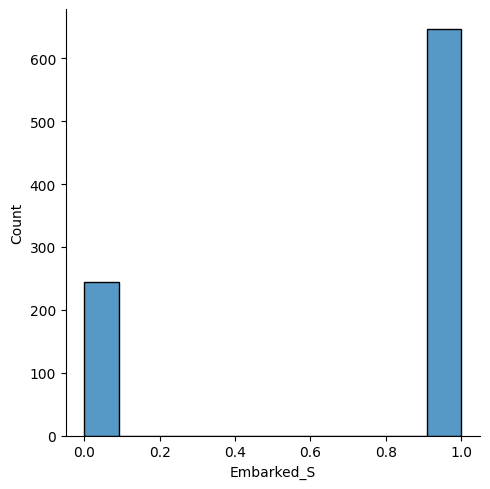

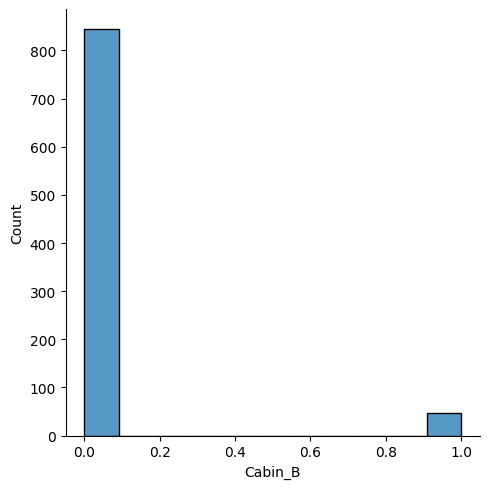

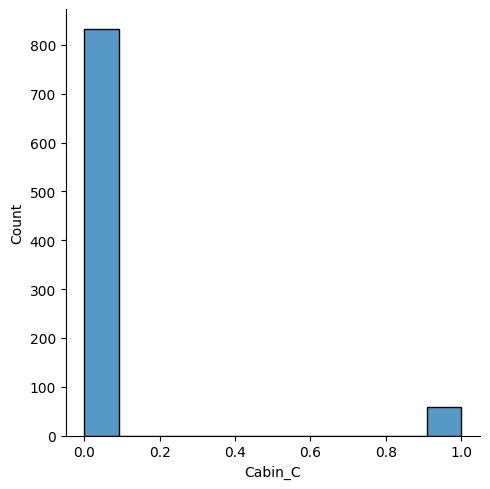

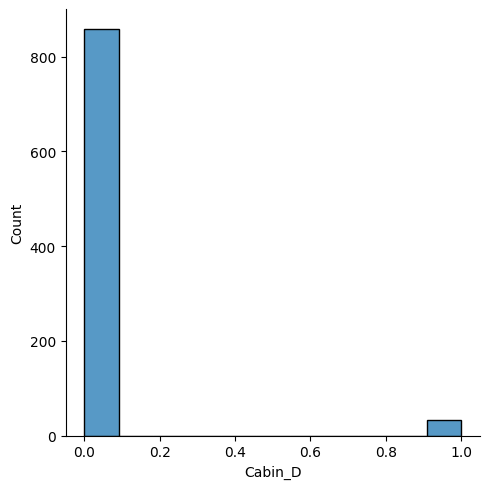

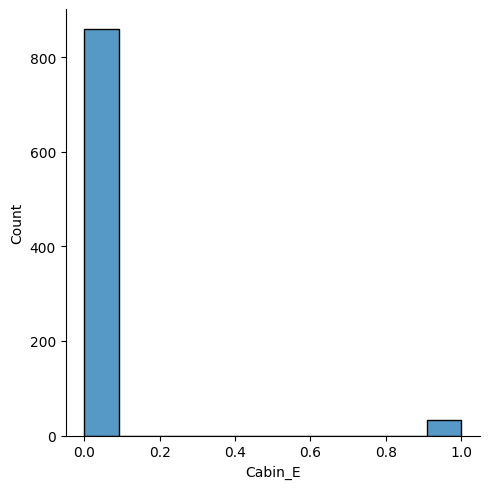

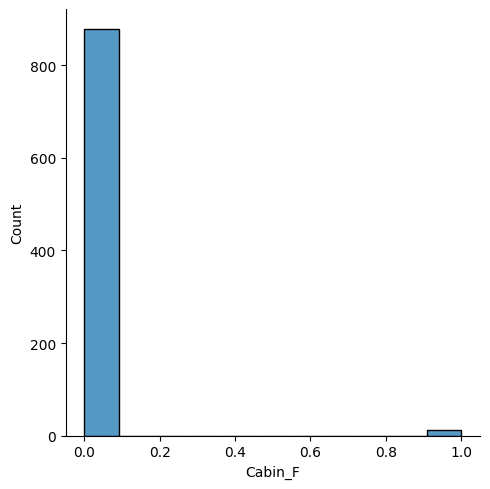

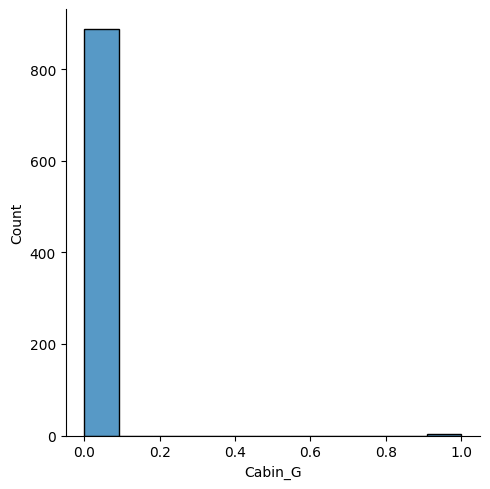

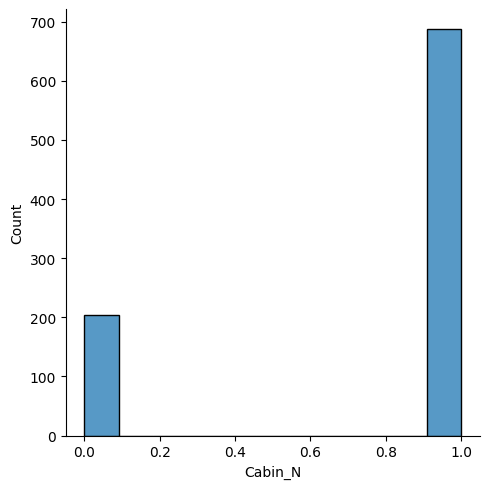

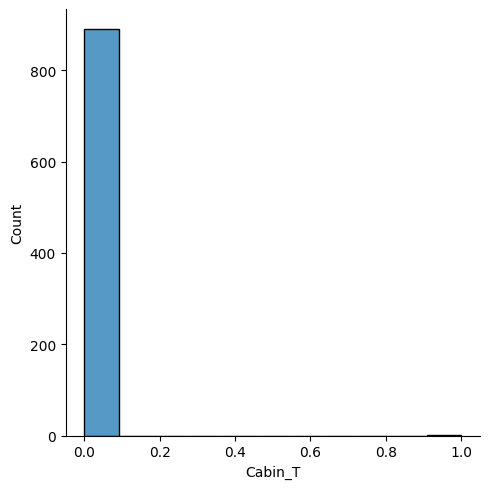

In [28]:
for feature in data_discrete.columns:
    sns.displot(data=x_train[feature], kind='hist')

## Time Data

In [29]:
for feature in data_time.columns:
    sns.displot(data=data[feature], kind='kde')

## Data Spread

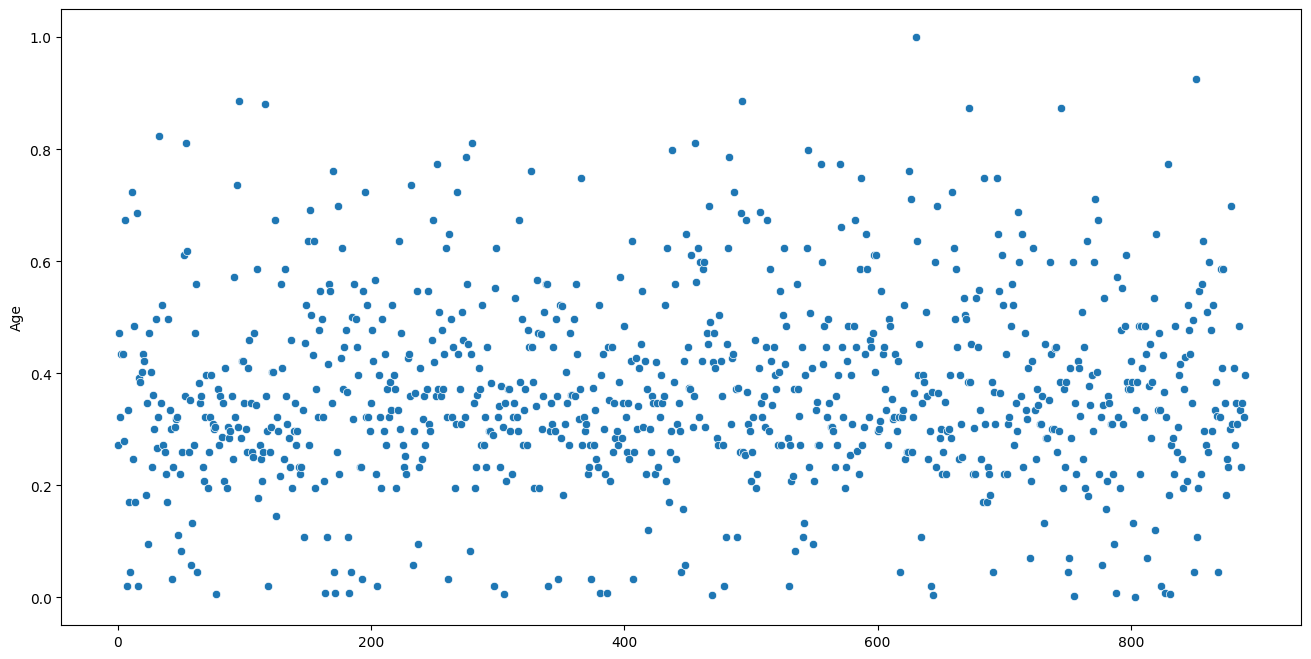

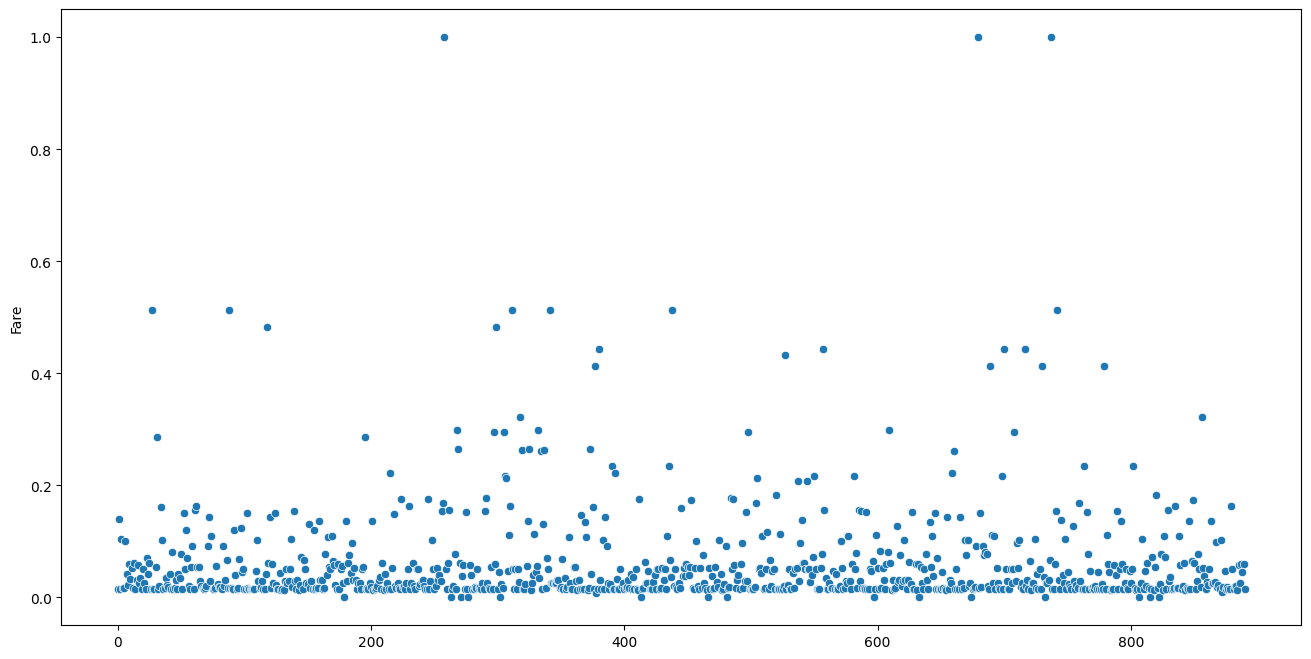

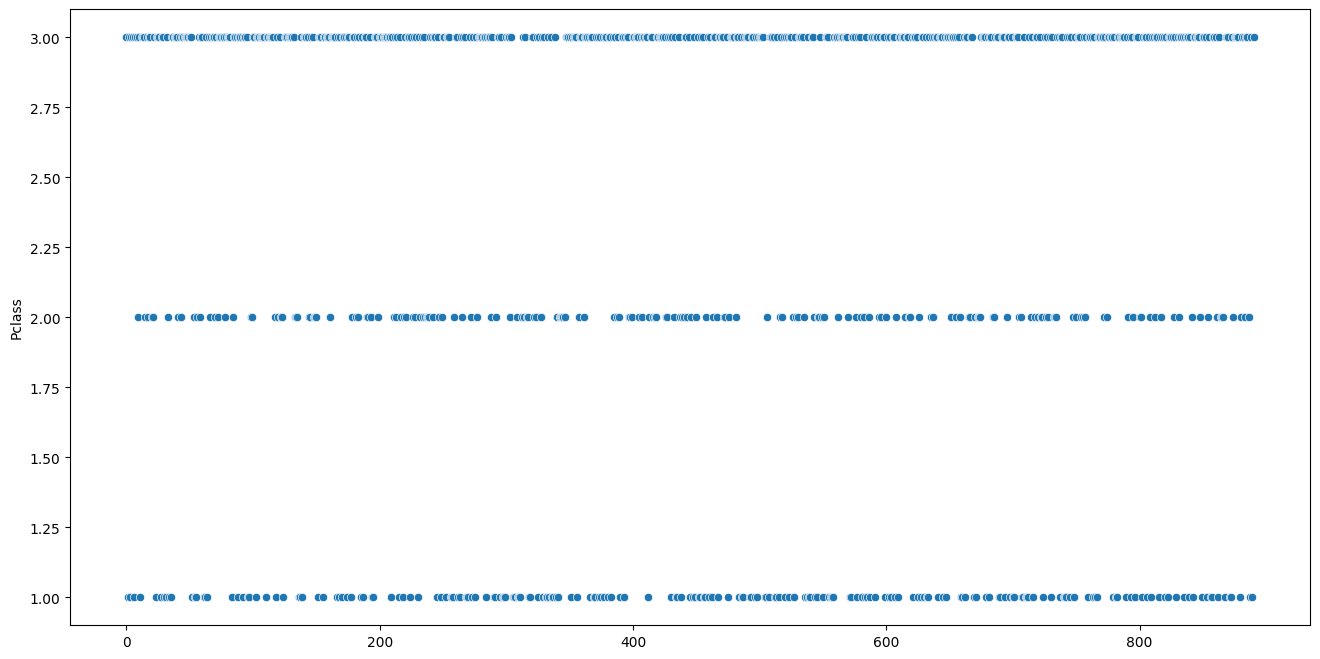

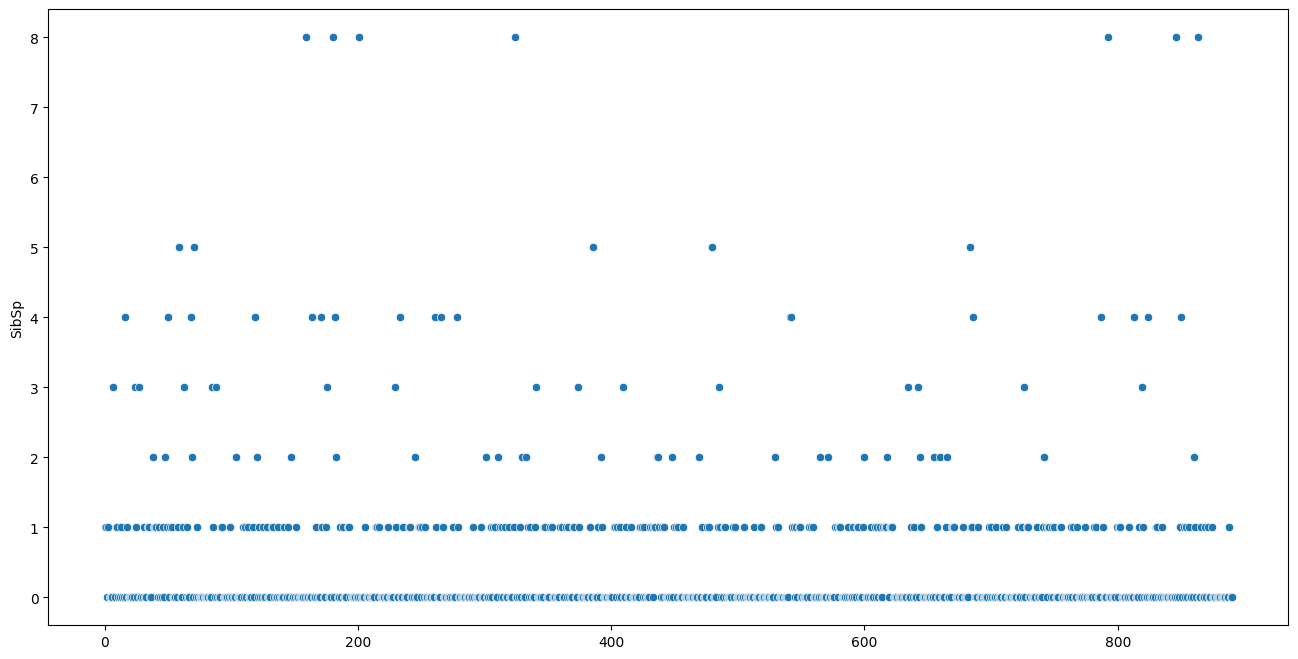

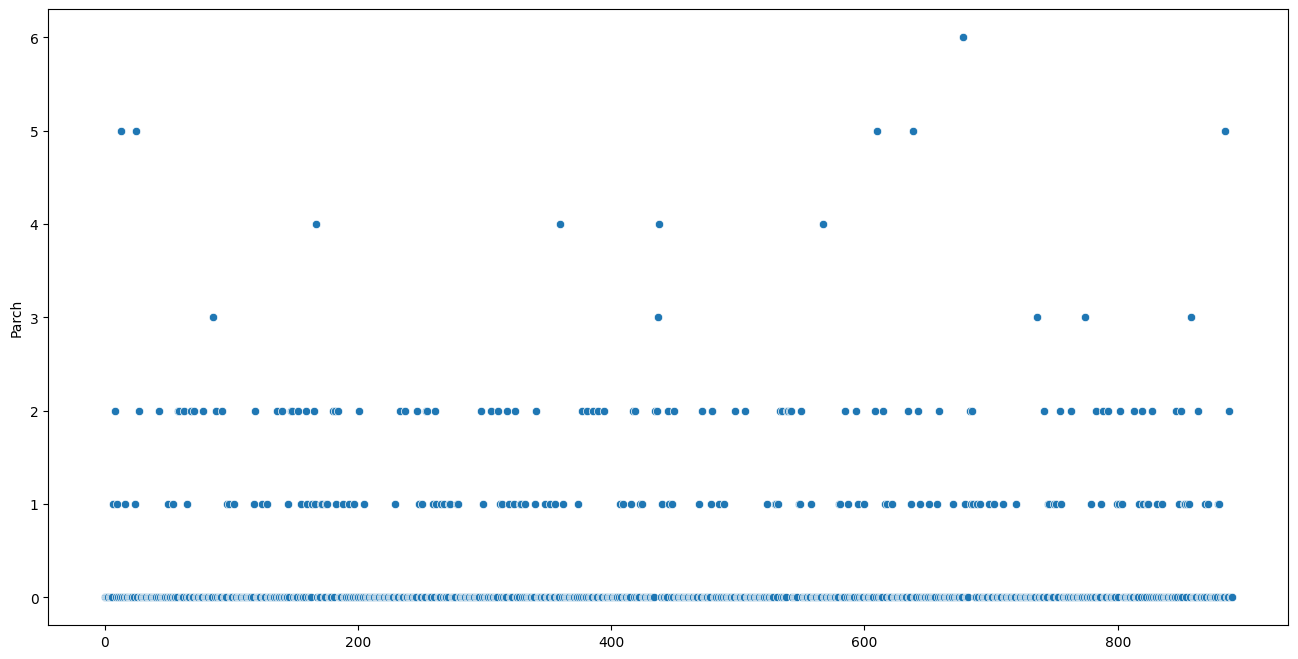

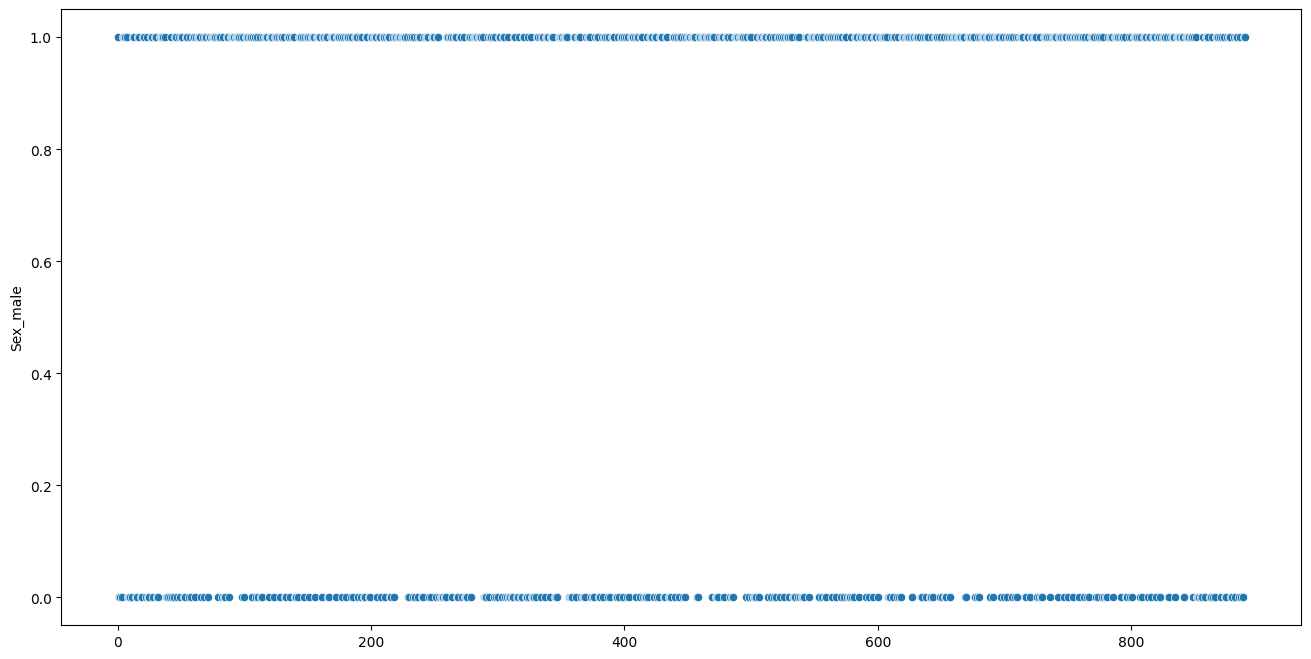

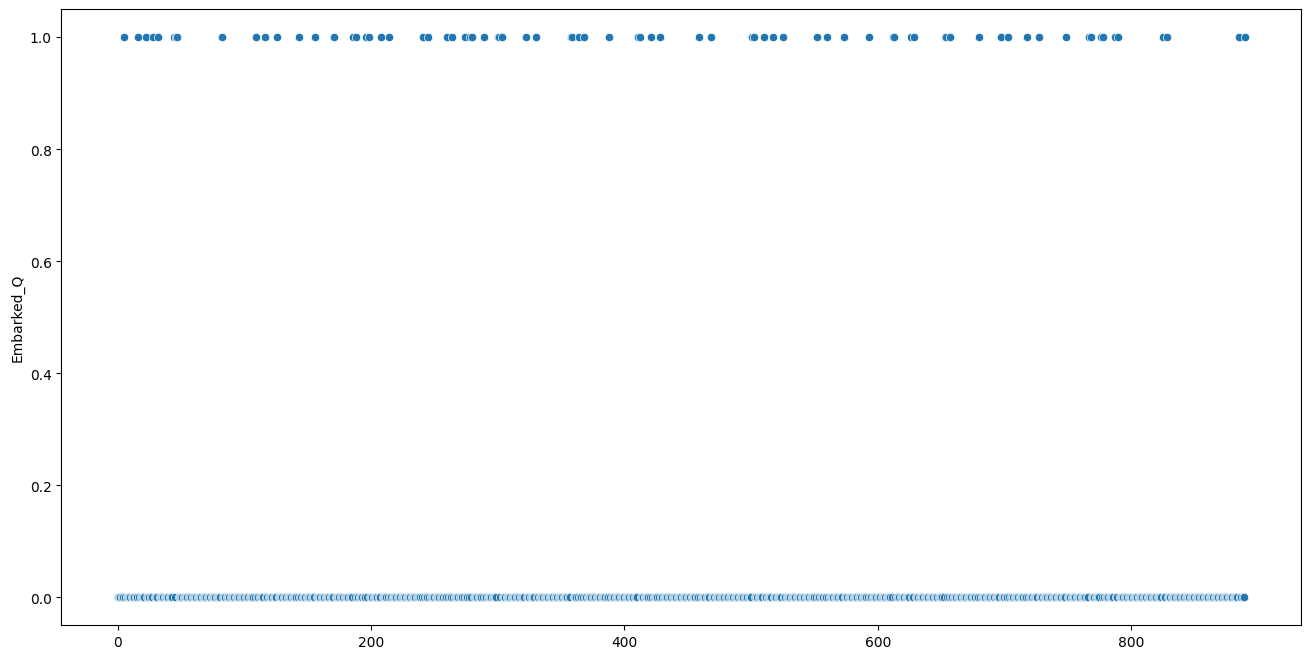

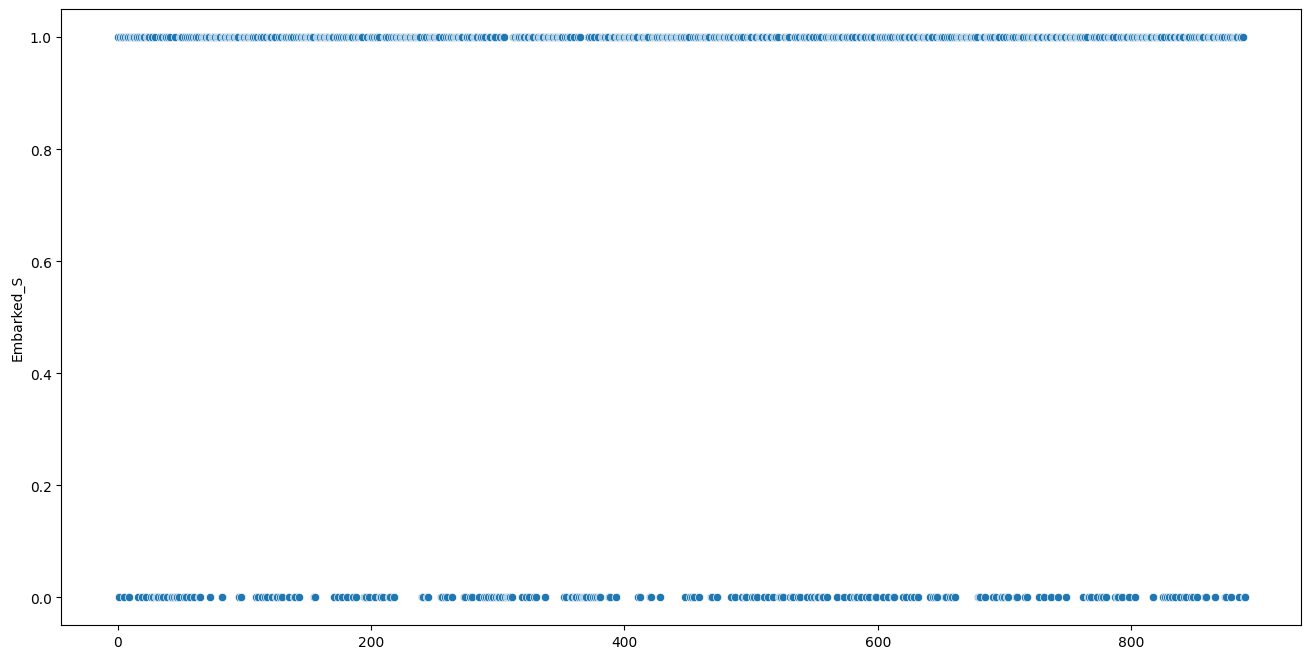

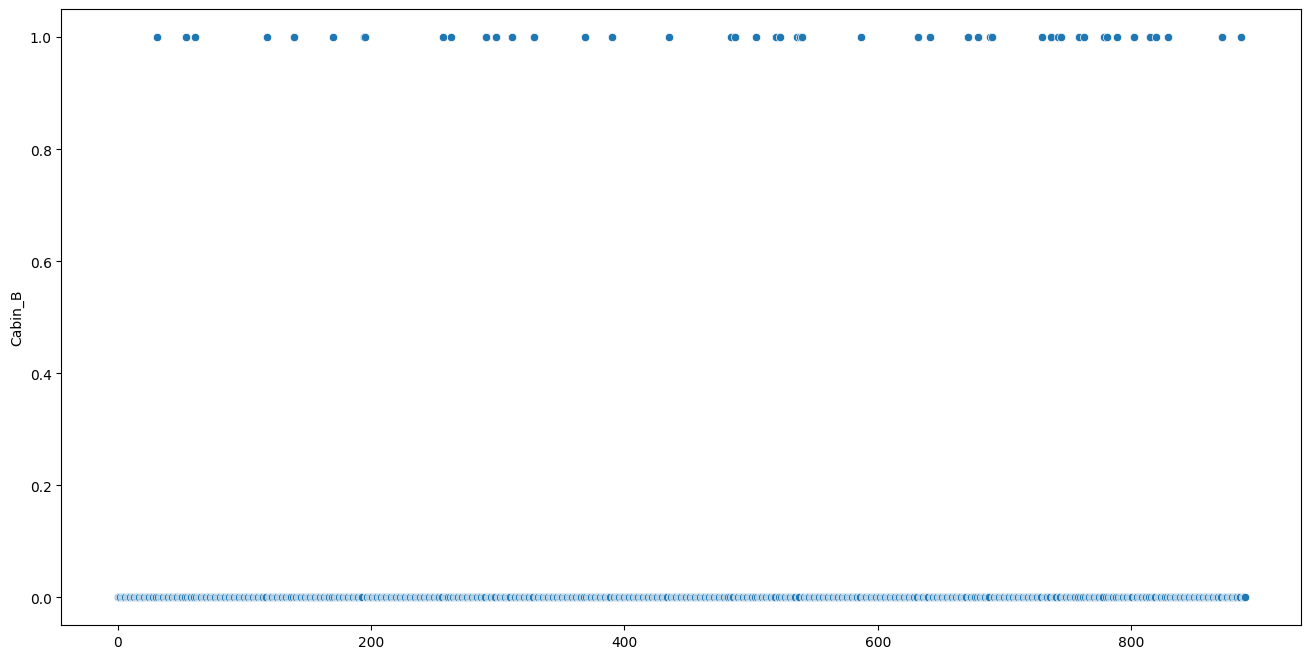

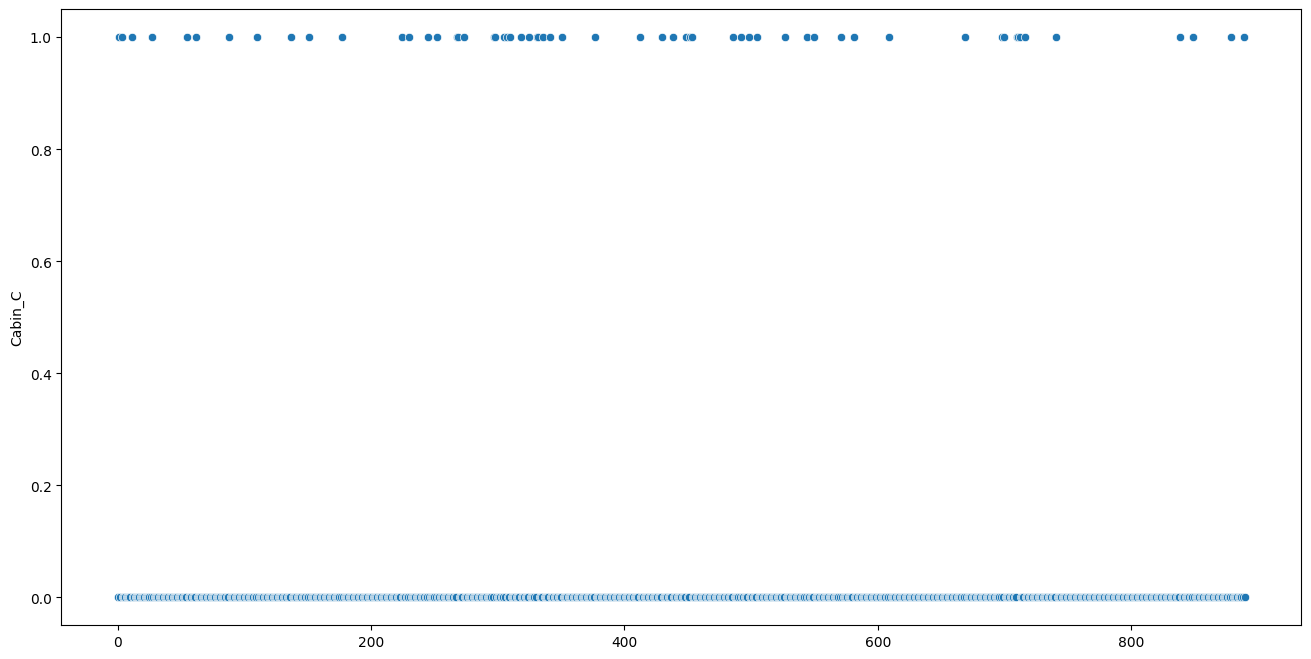

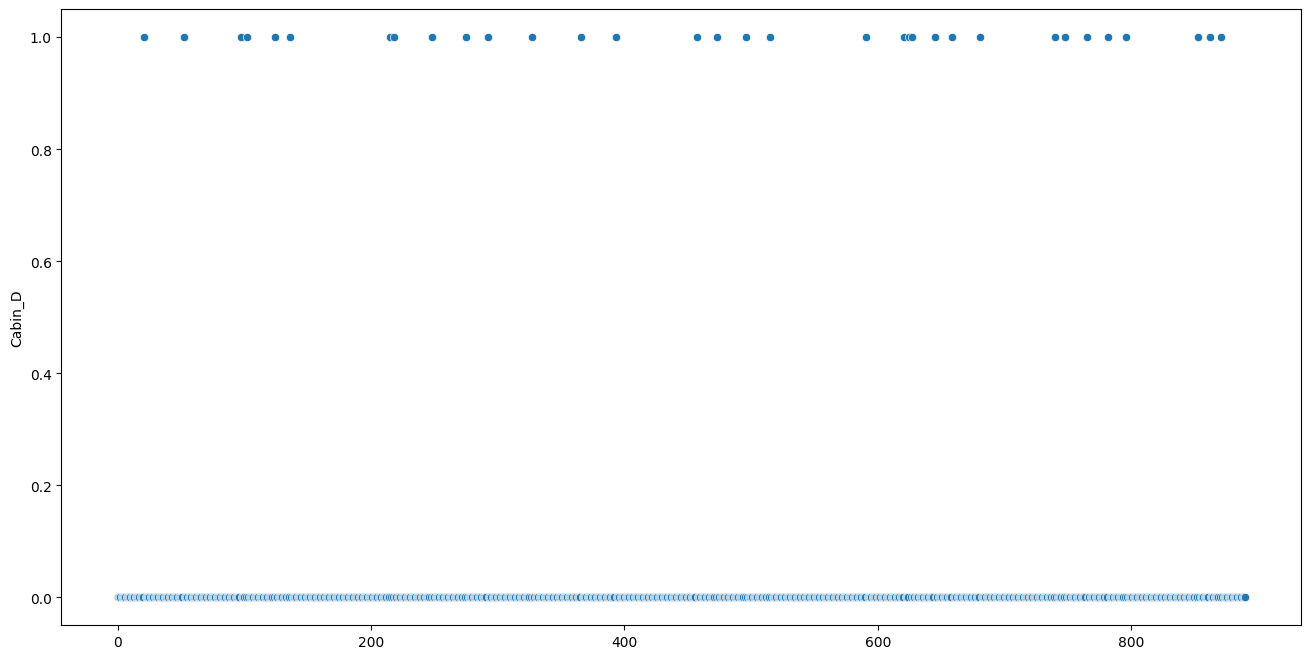

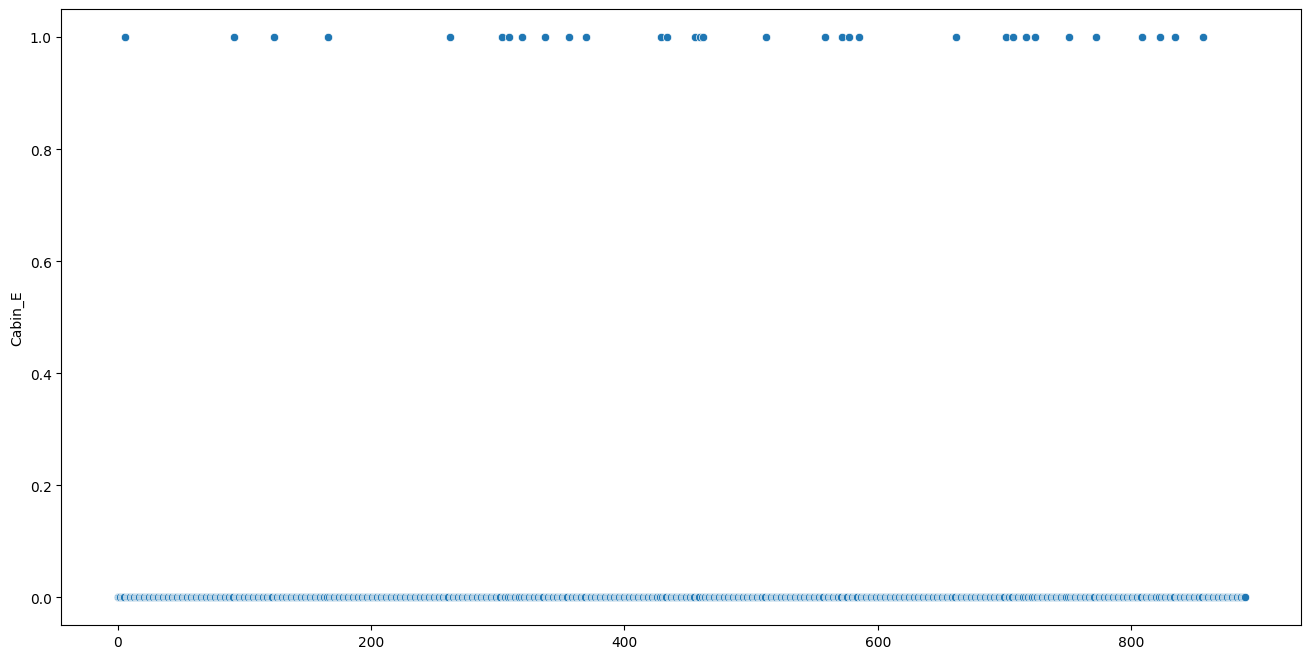

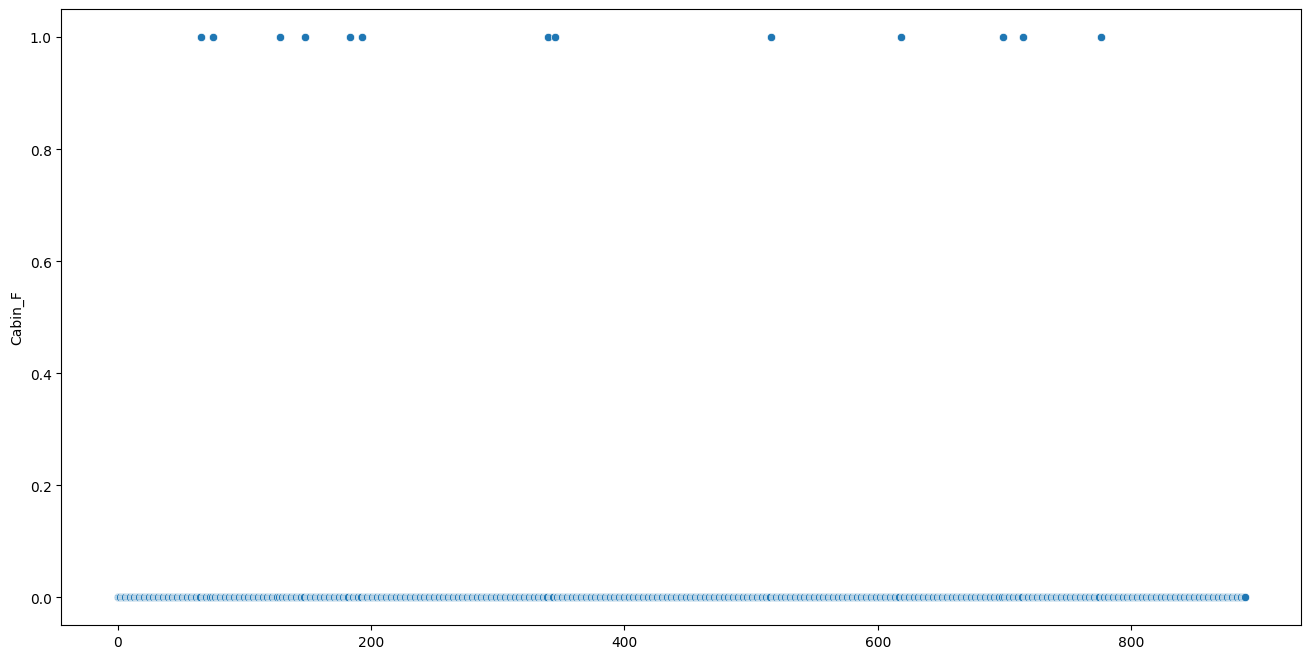

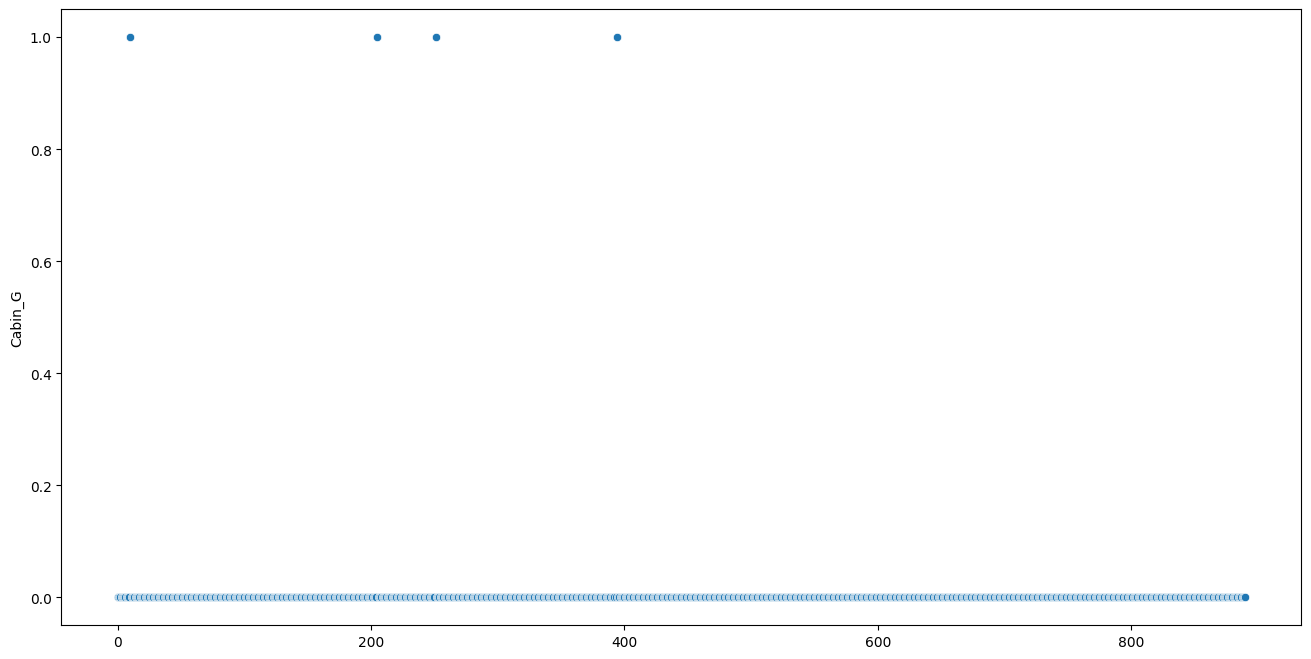

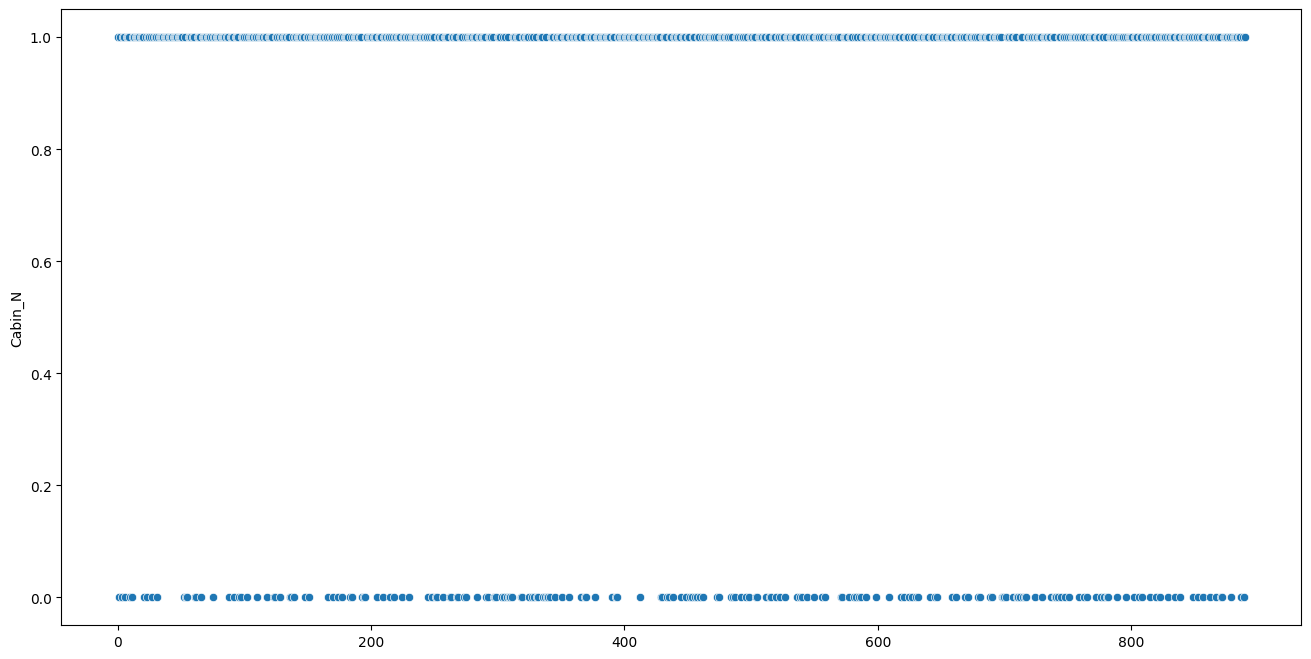

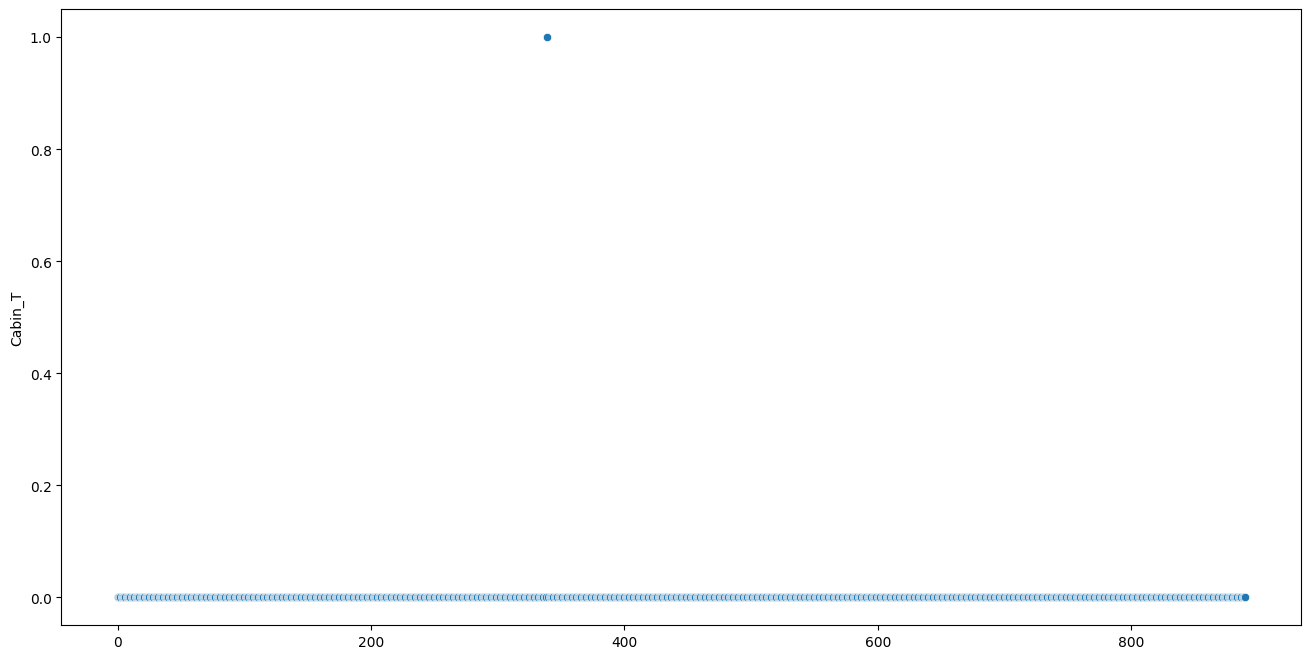

In [30]:
for feature in x_train.columns:
    plt.figure(figsize=(16,8))
    sns.scatterplot(data=x_train[feature])

## Correlation

In [31]:
pd.concat([x_train, y_train], axis=1).corr()

,Age,Fare,Pclass,SibSp,Parch,Sex_male,Embarked_Q,Embarked_S,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_N,Cabin_T,Survived
Age,1.000000,0.108606,-0.374770,-0.188745,-0.163136,0.081167,-0.043372,0.017414,0.089503,0.145497,0.139304,0.117048,-0.085605,-0.074890,-0.255588,0.038570,-0.059991
Fare,0.108606,1.000000,-0.549500,0.159651,0.216225,-0.182333,-0.117216,-0.162184,0.386297,0.364318,0.098878,0.053717,-0.033093,-0.025180,-0.482075,0.002224,0.257307
Pclass,-0.374770,-0.549500,1.000000,0.083081,0.018443,0.131900,0.221009,0.074053,-0.369572,-0.417048,-0.278690,-0.230091,0.011063,0.055561,0.725541,-0.052496,-0.338481
SibSp,-0.188745,0.159651,0.083081,1.000000,0.414838,-0.114631,-0.026354,0.068734,-0.034538,0.029251,-0.017575,-0.036865,0.001706,-0.001402,0.040460,-0.015907,-0.035322
Parch,-0.163136,0.216225,0.018443,0.414838,1.000000,-0.245489,-0.081228,0.060814,0.056498,0.030736,-0.019125,-0.016554,0.023694,0.072388,-0.036987,-0.015878,0.081629
Sex_male,0.081167,-0.182333,0.131900,-0.114631,-0.245489,1.000000,-0.074115,0.119224,-0.109689,-0.058649,-0.079248,-0.047003,-0.008202,-0.091031,0.140391,0.024728,-0.543351
Embarked_Q,-0.043372,-0.117216,0.221009,-0.026354,-0.081228,-0.074115,1.000000,-0.499421,-0.072579,-0.049776,-0.060318,-0.037897,-0.004113,-0.020654,0.129572,-0.010310,0.003650
Embarked_S,0.017414,-0.162184,0.074053,0.068734,0.060814,0.119224,-0.499421,1.000000,-0.102063,-0.068502,-0.052254,0.037812,0.033010,0.041356,0.101139,0.020643,-0.149683
Cabin_B,0.089503,0.386297,-0.369572,-0.034538,0.056498,-0.109689,-0.072579,-0.102063,1.000000,-0.062841,-0.046280,-0.045547,-0.028715,-0.015847,-0.433053,-0.007910,0.175095
Cabin_C,0.145497,0.364318,-0.417048,0.029251,0.030736,-0.058649,-0.049776,-0.068502,-0.062841,1.000000,-0.052225,-0.051398,-0.032403,-0.017883,-0.488683,-0.008926,0.114652


<AxesSubplot:>

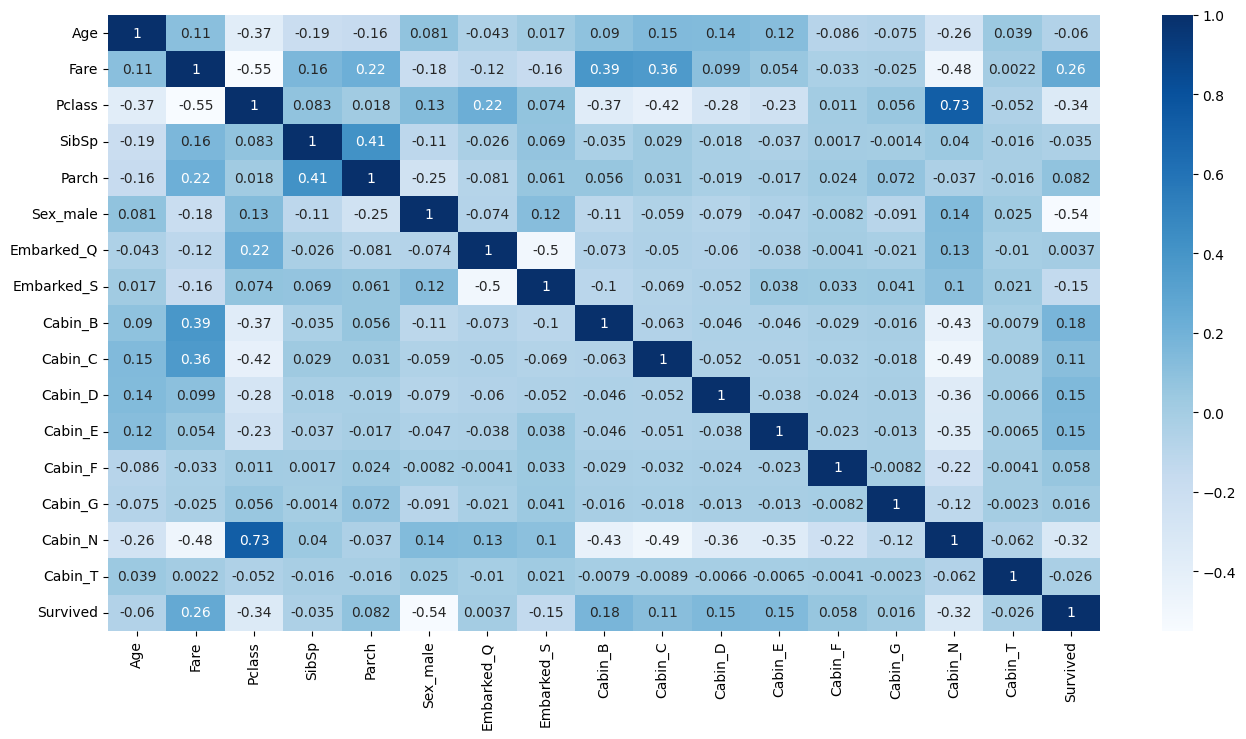

In [32]:
plt.figure(figsize=(16,8))
sns.heatmap(data=pd.concat([x_train, y_train], axis=1).corr(), annot=True, cmap='Blues')

## Questions and Insights Summary
- Most of the people were of Ages between 30-50
- Most people were in 3rd Class
- Most people were alone
- There were more males than females
- Did more poor people died than the rich people?
- Did more females survived than the males?
- Did they not even bother to register the poor people and thats why missing values are so many?

## Saving the model and Data

In [33]:
with open('model/preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [34]:
x_train.to_csv('data/interim/x_train.csv', index=False)
x_test.to_csv('data/interim/x_test.csv', index=False)
y_train.to_csv('data/interim/y_train.csv', index=False)
y_test.to_csv('data/interim/y_test.csv', index=False)

In [35]:
os.chdir(old_path)

## Conclusions
- Made Pipelines for data manipulation
- Learnt how to make custom functions in the pipeline and how to extract features from the pipeline
- Missing values were handled
- Categorical features were handled
- Outliers and Distributions were handled
- Some features had high correlation